In [119]:
import pyspark as ps
import warnings
import multiprocessing
import numpy as np

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

from pyspark.sql.functions import UserDefinedFunction, udf, monotonically_increasing_id
from pyspark.sql.functions import count, collect_list, split
from pyspark.sql.types import StringType, ArrayType, DoubleType, IntegerType

from pyspark.ml.feature import CountVectorizer, Normalizer, IDF, Tokenizer

In [37]:
# multiprocessing.cpu_count() 
try:
    sc = ps.SparkContext('local[8]')
    print "Just created a SparkContext"
except ValueError:
    warnings.warn("SparkContext already exists in this scope")

/Users/Kelly/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: SparkContext already exists in this scope


In [38]:
sqlContext = ps.SQLContext(sc)

In [99]:
df = sqlContext.read.json('reviews_100.json')

In [195]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# df.withColumn('id', sqlContext.range(0, 100).id).show(5)

In [71]:
def preprocess_review_text(text):
    stopwords_ = set(stopwords.words('english') + [str(i) for i in xrange(100)])
#     stemmer_ = SnowballStemmer('english')
    lemmatizer = WordNetLemmatizer()
    
    if (text == None):
        return []
    
    if (len(text) < 1):
        return []
    
    if (type(text) == unicode):
        text = text.encode('utf-8')
        
    replace_punctuation = string.maketrans(string.punctuation, ' '*len(string.punctuation))
    unpunctuated_text = text.translate(replace_punctuation)
    tokens = word_tokenize(unpunctuated_text)[:-5:] # reviewer username info lost here via array slice
    lowercased_tokens = [token.lower() for token in tokens]
    filtered_tokens = [w for w in lowercased_tokens if not w in stopwords_] 
    
#     stemmed = []
#     for token in filtered_tokens:
#         try:
#             stemmed.append(stemmer_.stem(token))
#         except:
#             # continue when stemmer doesn't work
#             continue

#     return stemmed
    lemmatized = []
    for token in filtered_tokens:
        try:
            lemmatized.append(lemmatizer.lemmatize(token))
        except:
            continue
            
    return lemmatized

In [165]:
token_udf = udf(lambda x: preprocess_review_text(x), ArrayType(StringType()))

df_reviews = df.select('brewery_name', 'beer_name', 'state', 'beer_style', 'text')

In [166]:
df_tokens = df_reviews.withColumn("tokens", token_udf('text'))

In [167]:
def get_all_tokens(tokens):
    return reduce(lambda x,y: x + y, tokens)

get_all_tokens_udf = udf(get_all_tokens, ArrayType(StringType()))

In [168]:
df_reviews_stemmed = df_tokens.groupby('brewery_name', 'beer_name', 'state', 'beer_style') \
                        .agg(get_all_tokens_udf(collect_list('tokens')) \
                        .alias('lemmatized_tokens'))
    
df_reviews_stemmed.printSchema()

root
 |-- brewery_name: string (nullable = true)
 |-- beer_name: string (nullable = true)
 |-- state: string (nullable = true)
 |-- beer_style: string (nullable = true)
 |-- lemmatized_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [12]:
# example user defined function
def up(text):
    return text.upper()
up_udf = udf(up, StringType())

In [ ]:
'''
BREAKKKKKK
'''

In [6]:
reviews_df = df.select('brewery_name', 'beer_name', 'state', 'beer_style', 'text')

root
 |-- brewery_name: string (nullable = true)
 |-- beer_name: string (nullable = true)
 |-- state: string (nullable = true)
 |-- beer_style: string (nullable = true)
 |-- text: string (nullable = true)



In [23]:
reviews_df.groupBy('brewery_name', 'beer_name', 'state')

In [189]:
grouped_reviews = reviews_df.groupBy('brewery_name', 'beer_name', 'state').agg(collect_list('text').alias('reviews'))
# grouped_reviews.collect()

In [187]:
def preprocess_reviews(reviews):
    stopwords_ = set(stopwords.words('english'))
    stemmer_ = SnowballStemmer('english')
    
    if (reviews == None):
        return []
    
    if (len(reviews) < 1):
        return []
    
    stemmed = []
    for text in reviews:
        if (type(text) == unicode):
            text = text.encode('utf-8')
        
        replace_punctuation = string.maketrans(string.punctuation, ' '*len(string.punctuation))
        unpunctuated_text = text.translate(replace_punctuation)
        tokens = word_tokenize(unpunctuated_text)[:-5:] # reviewer username info lost here via array slice
        lowercased_tokens = [token.lower() for token in tokens]
        filtered_tokens = [w for w in lowercased_tokens if not w in stopwords_] 
        try:
            stemmed += [stemmer_.stem(w) for w in filtered_tokens]
        except:
            stemmed += [stemmer_.stem(w) for w in filtered_tokens[:-1:]] # review text is more than 999 characters
    return(stemmed)

In [20]:
test = '''Poured from a 12oz bottle ($6.99/four-pack) into a teku:\n\nAppearance: pours a bright copper-orange, with a thick, fluffy head. The body isn't quite translucent, but I wouldn't call it hazy either....somewhere in between. Leaves tons of sticky lacing.\n\nSmell: disappointed in this area, as I didn't get all that much from the hops. I got some dry, crackery scent from the malt, and maybe a little bit of bitterness, but the hops were a disappointment in a style that definitely needs hop aromatics.\n\nTaste: starts off with some nice, mellow fruit flavor. I got a little bit of melon, some pineapple rind.  Orange pith, not so much the flesh. Lots of bitterness, perhaps a little bit over on the bitter balance. The magnum definitely comes through on the finish much more than the El Dorado, though both give this beer a distinctly bitter flavor. Not necessarily a bad thing, but it's not the en vogue flavor right now. Nicely balanced between malt and hops.\n\nFeel: medium-bodied, with light to medium carbonation, and a semi-thick mouthfeel. Leaves a kind of dry, bitter finish.\n\nOverall: a solid first IPA from a new brewery. Combined with the fact that half of all proceeds are donated to different charities, this'll be a solid purchase, especially at the relatively cheap price point.\xa01,287 charactersTheElectricOne, Mar 25, 2016'''

reviews = [u'Solidly amber in color with just a touch of haze.  Small but lasting head which leaves decent latticed lace.\n\nVery nice blended smell of caramel malt (like an English IPA) with a pleasant floral hop (more like an East Coast US IPA).\n\nStarts mild with some toastiness on the tongue.  The hop is straight up bitterness and stronger than I expected based on the smell.  Highly carbonated and neutral in body.  Long aftertaste, but again, the flavor is straight forward.  \n\nOverall, I do like this IPA.  The interplay between the malt and hop is fun, but neither is very complex.\xa0575 characterssmcolw, Apr 22, 2016', u'Pours a slightly hazy and light amber in color with a minimal off white head that quickly faded to only a few bubbles at the edges. It has an almost murky/muddy appearance. Aroma is almost completely devoid of hop presence with a fair amount of caramelly malts. Taste is like the aroma, hop flavor is low with only hints of citrus and a few floral notes. Caramel malt character is offset by a relatively high bitterness that has a touch of astringency at the end. Medium body and moderate carbonation. Overall a very mediocre beer. I found the hop presence lacking, the caramel malts a bit heavy handed and the bitterness out of whack. I do really like the label (which is the reason that I took a chance on an unknown and picked this up).\xa0739 charactersmnj21655, Apr 19, 2016', u'A- Snifter pour from the narrow 12oz bottle with a deep orange-amber body and a foamy off-white cap that rises to just about one finger high. Head falls fairly fast to a medium ring and lacing is in sheets.\n\nS- Really not a whole lot to go by especially for the IPA style. A hint of orange citrus hops is trumped by medium caramelized malts and yeast bread notes. A bit toasty.\n\nT- Fairly malty focus carries over from the aroma with cereal grains, toast, pale caramel and raw base malt notes coming out. Hops are more present in the finish with a heavy spicy and earthy presence as well citrus, herbal tea and floral hints.\n\nMF- Texture falls somewhere between silky, frothy and a tad creamy in a medium body that leans just towards the light end. Carbonation is moderate and the finish contains an herbal bitterness.\n\nA moderate malt presence interferes with the brightness of the hops in a fairly forgettable brew in an ultra competitive style. IPAs can be balanced but this one does not excel at that.\xa01,005 characterscbutova, Mar 30, 2016', u"Poured from a 12oz bottle ($6.99/four-pack) into a teku:\n\nAppearance: pours a bright copper-orange, with a thick, fluffy head. The body isn't quite translucent, but I wouldn't call it hazy either....somewhere in between. Leaves tons of sticky lacing.\n\nSmell: disappointed in this area, as I didn't get all that much from the hops. I got some dry, crackery scent from the malt, and maybe a little bit of bitterness, but the hops were a disappointment in a style that definitely needs hop aromatics.\n\nTaste: starts off with some nice, mellow fruit flavor. I got a little bit of melon, some pineapple rind.  Orange pith, not so much the flesh. Lots of bitterness, perhaps a little bit over on the bitter balance. The magnum definitely comes through on the finish much more than the El Dorado, though both give this beer a distinctly bitter flavor. Not necessarily a bad thing, but it's not the en vogue flavor right now. Nicely balanced between malt and hops.\n\nFeel: medium-bodied, with light to medium carbonation, and a semi-thick mouthfeel. Leaves a kind of dry, bitter finish.\n\nOverall: a solid first IPA from a new brewery. Combined with the fact that half of all proceeds are donated to different charities, this'll be a solid purchase, especially at the relatively cheap price point.\xa01,287 charactersTheElectricOne, Mar 25, 2016"]
# reviews

In [22]:
type(preprocess_review_text(test))
# tokens = preprocess_reviews(reviews)

# tokenizer_udf = udf(lambda x : preprocess_reviews(x), ArrayType(StringType()))

# df_tokens = grouped_reviews.withColumn("tokens", tokenizer_udf(grouped_reviews.reviews))
# df_tokens.printSchema()

list

In [169]:
from pyspark.sql.functions import row_number
from pyspark.sql.window import Window

cv = CountVectorizer(inputCol='lemmatized_tokens', outputCol='features_tf')
cv_model = cv.fit(df_reviews_stemmed)
df_reviews_stemmed = cv_model.transform(df_reviews_stemmed)

normalizer = Normalizer(inputCol='features_tf', outputCol='features_normalized')
df_reviews_stemmed = normalizer.transform(df_reviews_stemmed)

In [171]:
idf = IDF(inputCol='features_normalized', outputCol='features')
idf_model = idf.fit(df_reviews_stemmed)
df_features = idf_model.transform(df_reviews_stemmed)

df_features = df_features.withColumn('beer_id', row_number().over(
            Window.orderBy('beer_style')) - 1)

# TODO: add a beer_id from 0 to len(distinct beers)-1 
df_beers = df_features.select('beer_id', 'brewery_name', 'beer_name', 'state', 'beer_style', 'features')

In [133]:
df_reviews_stemmed.printSchema()

root
 |-- brewery_name: string (nullable = true)
 |-- beer_name: string (nullable = true)
 |-- state: string (nullable = true)
 |-- beer_style: string (nullable = true)
 |-- lemmatized_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features_tf: vector (nullable = true)
 |-- features_normalized: vector (nullable = true)



In [172]:
df_beers.show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|beer_id|        brewery_name|           beer_name|               state|          beer_style|            features|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      0|14th Star Brewing...|           Valor Ale|             Vermont|American Amber / ...|(1542,[0,1,2,3,4,...|
|      1|10-56 Brewing Com...|Charlie's Cherry ...|             Indiana| American Blonde Ale|(1542,[2,4,14,15,...|
|      2|         Beer Lab HI|         Abunai.P.A.|              Hawaii|American Double /...|(1542,[5,18,39,47...|
|      3|       2 Row Brewing|      Random Red Rye|                Utah|American Double /...|(1542,[0,1,2,3,4,...|
|      4|101 North Brewing...|Heroine India Pal...|          California|        American IPA|(1542,[0,1,2,3,4,...|
|      5| AntiVillain Ale Co.|          8-Bit IPA!|        Rhode Island|        

In [196]:
df_beers.select('beer_name').rdd.flatMap(lambda x: x).collect()

beers = df_beers.select('beer_name', 'beer_id').collect()
[str((i.beer_id, i.beer_name)[1]) for i in beers]

# source = []
# d = {}
# for i in xrange(0, 20):
#     d['id'] = bleh[i][0]
#     d['name'] = bleh[i][1]
#     source.append(d.copy())
#     print d

['Valor Ale',
 "Charlie's Cherry - Cheery Chamomile Blonde Bombshell",
 'Abunai.P.A.',
 'Random Red Rye',
 'Heroine India Pale Ale',
 '8-Bit IPA!',
 'The Rock IPA',
 "Bosco's Revenge",
 'Cashmere Hammer',
 'Farm House',
 'Two Headed Unicorn',
 'Mystery Barrel Sour 1.0',
 "Monks' Dubbel Ale",
 'Manly Barley Wine Ale',
 'Harvest Ale',
 'Black Gold',
 'Red Bean And Rice Ale',
 'Sweet Vanilla Oatmeal Stout',
 'Koko Beware',
 'Dark Saison']

In [184]:
source

[{'beer': u'Valor Ale', 'id': 0},
 {'beer': u"Charlie's Cherry - Cheery Chamomile Blonde Bombshell", 'id': 1},
 {'beer': u'Abunai.P.A.', 'id': 2},
 {'beer': u'Random Red Rye', 'id': 3},
 {'beer': u'Heroine India Pale Ale', 'id': 4},
 {'beer': u'8-Bit IPA!', 'id': 5},
 {'beer': u'The Rock IPA', 'id': 6},
 {'beer': u"Bosco's Revenge", 'id': 7},
 {'beer': u'Cashmere Hammer', 'id': 8},
 {'beer': u'Farm House', 'id': 9},
 {'beer': u'Two Headed Unicorn', 'id': 10},
 {'beer': u'Mystery Barrel Sour 1.0', 'id': 11},
 {'beer': u"Monks' Dubbel Ale", 'id': 12},
 {'beer': u'Manly Barley Wine Ale', 'id': 13},
 {'beer': u'Harvest Ale', 'id': 14},
 {'beer': u'Black Gold', 'id': 15},
 {'beer': u'Red Bean And Rice Ale', 'id': 16},
 {'beer': u'Sweet Vanilla Oatmeal Stout', 'id': 17},
 {'beer': u'Koko Beware', 'id': 18},
 {'beer': u'Dark Saison', 'id': 19}]

In [151]:
top1 = np.argsort(df_beers.take(1)[0].features.toArray())[::-1][:10]
top2 = np.argsort(df_beers.take(5)[4].features.toArray())[::-1][:10]

In [51]:
vocab = {idx: val for idx, val in enumerate(cv_model.vocabulary)}

In [152]:
print [vocab[idx] for idx in top1]
print [vocab[idx] for idx in top2]

[u'roasted', u'body', u'hop', u'much', u'thin', u'grapefruit', u'floral', u'malt', u'definitely', u'caramel']
[u'hop', u'style', u'roasted', u'much', u'bad', u'good', u'thin', u'think', u'body', u'quickly']


In [126]:
def get_top_features(features):
    return np.argsort(features)[::-1][:10]
    
top_features_udf = udf(lambda beer: len(beer), IntegerType())

df_beers = df_beers.withColumn('top_features', top_features_udf('features'))
df_beers.printSchema()

root
 |-- id: integer (nullable = true)
 |-- brewery_name: string (nullable = true)
 |-- beer_name: string (nullable = true)
 |-- state: string (nullable = true)
 |-- beer_style: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- top_features: integer (nullable = true)



In [27]:
'''create a column for the top 10 features of each beer'''

In [25]:
# df_beers.select('features').agg(collect_list('features')).collect()[0].

In [272]:
def sparse_vector_to_matrix(vectors):
    return reduce(lambda x, y: np.vstack((x,y)), vectors)

matrix_udf = udf(sparse_vector_to_matrix, RowMatrix)

In [288]:
df_beers.select('features').agg(matrix_udf(collect_list('features')))

DataFrame[sparse_vector_to_matrix(collect_list(features, 0, 0)): array<double>]

In [301]:
from pyspark.mllib.linalg.distributed import IndexedRow, IndexedRowMatrix
matrix = RowMatrix(df_beers.select('features').rdd)

In [313]:
df_beers = df_beers.withColumn('beer_id', monotonically_increasing_id())

In [321]:
# IndexedRowMatrix(df_beers.select('beer_id', 'features').rdd.map(lambda row: IndexedRow(*row)))

In [139]:
mat = np.array([x.features.toArray() for x in df_beers.rdd.toLocalIterator()])

In [140]:
mat.T.shape

(1542, 20)

In [31]:
U, s, VT = np.linalg.svd(mat.T, full_matrices=False)

In [32]:
U.shape, s.shape, VT.shape

((4644, 181), (181,), (181, 181))

In [23]:
import matplotlib.pyplot as plt
% matplotlib inline

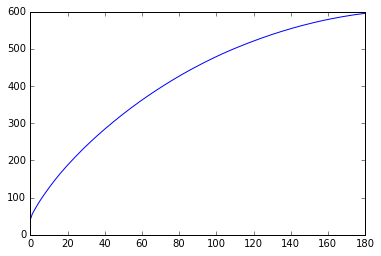

In [35]:
cumulative = np.cumsum(s ** 2)
# plt.bar(np.arange(len(cumulative)), cumulative)
plt.plot(cumulative)

In [36]:
total_energy = np.sum(s ** 2)
total_energy * .9

535.70908256512814

In [165]:
from scipy import sparse
A =  np.array([[0, 1, 0, 0, 1], [0, 0, 1, 1, 1],[1, 1, 0, 1, 0]])

svd = TruncatedSVD(3)
# lsa = make_pipeline(svd, Normalizer(copy=False))
# X = lsa.fit_transform(A)
X = svd.fit_transform(A)
# A_sparse = sparse.csr_matrix(A)
cosine_similarity(X)

array([[ 1.        ,  0.40824829,  0.40824829],
       [ 0.40824829,  1.        ,  0.33333333],
       [ 0.40824829,  0.33333333,  1.        ]])

In [159]:
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.utils.sparsefuncs import mean_variance_axis
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
# 
# U, s, VT = randomized_svd(mat.T, n_components=20)
svd = TruncatedSVD(n_components=25)
svd_model = svd.fit(mat)
vt = svd_model.transform(mat)
print mat.shape
print vt.shape
# print np.argsort(cosine_similarity(n.fit_transform(vt))[2])[::-1]
# print np.argsort(cosine_similarity(vt)[8])[::-1]
# svd_model.explained_variance_ratio_
# svd_model.components_
# print svd_model.components_[0]
# print VT[0]

# lsa = make_pipeline(svd, Normalizer(copy=False))
# X = lsa.fit_transform(mat.T)

# # cosine_similarity(X, dense_output=False)
# X.shape

# print np.argsort(svd_model.components_[3])[::-1][:10]

print cosine_similarity(vt)[6]

np.argsort(cosine_similarity(vt)[6])[::-1]

similarity_matrix = cosine_similarity(vt)
map(lambda x: np.argsort(x)[::-1][1:6], similarity_matrix)

(20, 1542)
(20, 20)
[u'caramel', u'beer', u'taste', u'like', u'dark', u'malt', u'hop', u'head', u'flavor', u'brown']
[u'malt', u'caramel', u'beer', u'taste', u'like', u'dark', u'hop', u'head', u'flavor', u'brown']
[  1.46302134e-01   3.44733436e-02   1.87536486e-02   1.20128381e-01
   1.59761414e-01   1.42771713e-01   1.00000000e+00   2.97201127e-03
   5.49948993e-02   9.00583611e-03   3.88661564e-02   1.63747160e-02
   6.15921770e-02   2.84939349e-02   1.11723173e-01   4.79661325e-02
   6.08241623e-02   5.13478149e-16   1.47516457e-02   5.42356981e-02]


[array([ 4,  5, 14, 15, 12]),
 array([10, 15, 14,  0,  5]),
 array([ 4,  0, 11,  7, 14]),
 array([ 4, 14,  0,  5, 19]),
 array([ 0,  5, 14,  3, 12]),
 array([ 0,  4, 14,  3, 15]),
 array([ 4,  0,  5,  3, 14]),
 array([ 2,  5,  3, 14,  0]),
 array([15, 14, 17,  0,  4]),
 array([14, 19, 12,  0,  4]),
 array([ 0,  1, 14,  4,  5]),
 array([ 2,  0, 14, 10, 13]),
 array([14,  0, 19,  4, 15]),
 array([ 0, 14,  4,  5,  3]),
 array([ 0, 15,  4,  8,  5]),
 array([14,  8,  0, 12,  5]),
 array([ 4, 14,  0,  6,  3]),
 array([ 8, 15, 14, 18,  0]),
 array([15, 14,  8,  0, 13]),
 array([14, 12,  4,  0, 15])]

In [60]:
# https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/decomposition/truncated_svd.py#L174
# X_transformed = U * s
# exp_var = np.var(X_transformed, axis=0)
# if sp.issparse(mat.T):
#     _, full_var = mean_variance_axis(mat.T, axis=0)
#     full_var = full_var.sum()
# else:
#     full_var = np.var(mat.T, axis=0).sum()
# explained_variance_ratio = exp_var / full_var
# np.sum(explained_variance_ratio)
# explained_variance_ratio

In [57]:
from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

U, Sigma, VT = randomized_svd(mat.T, 
                              n_components=14,
                              n_iter=5,
                              random_state=1234)

normalizer = Normalizer(copy=False)

normalizer.fit_transform(VT)[0]

array([ 0.13231394,  0.29072093,  0.29220745,  0.29749055,  0.3287772 ,
        0.24132966,  0.08440721,  0.22316412,  0.20344435,  0.18605772,
        0.29176682,  0.14992493,  0.31066487,  0.21881925,  0.12685185,
        0.1725704 ,  0.17279347,  0.16417279,  0.22588892,  0.13824719])

In [ ]:
# Calculate the power that each singular value represents, where power is the same as the variance of a dimension
# Total power is the sum  of the power of each singular value.
cumsum = np.cumsum(Sigma ** 2)
# plt.plot(cumsum)

total_energy = np.sum(Sigma ** 2)
print total_energy * .9

print cumsum

def find_num_singular_values_to_retain_power(sigma, percent_power):
    sv_power = sigma ** 2
    cumsum = np.cumsum(sv_power)
    total_energy = np.sum(sv_power)
    val = total_energy * percent_power
    for i in xrange(len(cumsum) -1):
        if cumsum[i] < val:
            idx1 = i
        else:
            idx2 = i
            break
            
    print idx1, idx2
    
find_num_singular_values_to_retain_power(Sigma, 0.9)

In [42]:
from sklearn.metrics.pairwise import cosine_similarity
#
# cosine_similarity(VT.T)
VT

array([[  1.32313944e-01,   2.90720934e-01,   2.92207451e-01,
          2.97490547e-01,   3.28777203e-01,   2.41329658e-01,
          8.44072129e-02,   2.23164116e-01,   2.03444353e-01,
          1.86057722e-01,   2.91766822e-01,   1.49924928e-01,
          3.10664874e-01,   2.18819249e-01,   1.26851852e-01,
          1.72570405e-01,   1.72793469e-01,   1.64172789e-01,
          2.25888923e-01,   1.38247187e-01],
       [ -7.44174684e-02,   2.01129859e-02,  -1.16336921e-01,
         -9.89495635e-02,   1.55020982e-01,  -9.93250664e-02,
         -3.85989064e-02,  -6.65909994e-02,  -1.32767639e-01,
          5.57685470e-02,   8.69902149e-01,  -9.45238929e-02,
         -5.79443616e-02,  -9.54801237e-02,  -1.55312041e-01,
         -9.09688735e-02,  -1.30551147e-01,  -6.77512213e-02,
         -8.77345089e-02,  -2.65154233e-01],
       [ -6.10028824e-02,  -1.40202200e-02,  -6.34463526e-02,
         -6.21724263e-02,   3.50483975e-04,  -2.94864040e-02,
         -1.63572835e-02,  -4.62769660e-02

In [39]:
VT[:, 2]

array([ 0.29220745, -0.11633692, -0.06344635, -0.05125732, -0.06363629,
        0.05653955, -0.11001875,  0.00537593, -0.10423678,  0.17767858,
       -0.05138166,  0.05960164, -0.15752648, -0.36938543])

In [97]:
'''LSI Example'''
A = np.array([[1, 1, 1], [0, 1, 1], [1, 0, 0], [0, 1, 0], [1, 0, 0], [1, 0, 1], [1, 1, 1], [1, 1, 1], [1, 0, 1], [0, 2, 0], [0, 1, 1]])

In [154]:
U, s, VT = np.linalg.svd(mat.T, full_matrices=False)

In [105]:
qt = np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1])

In [106]:
qt.dot(U2).dot(np.linalg.inv(S2))

array([-0.21400262,  0.18205705])

In [114]:
tsvd = TruncatedSVD(n_components=15)
tsvd.fit_transform(mat.T).shape

(1370, 15)

In [133]:
for i in range(0,15):
    print "component ", i
    idxs = np.argsort(tsvd.components_[i]).tolist()[::-1]
    for idx in idxs:
        print cv_model.vocabulary[idx]

component  0
pour
dark
beer
malt
head
like
tast
medium
flavor
finish
bodi
brown
light
sweet
aroma
caramel
carbon
hop
bitter
nice
component  1
like
pour
brown
malt
nice
dark
flavor
aroma
hop
medium
light
caramel
finish
tast
beer
head
sweet
bodi
bitter
carbon
component  2
carbon
like
pour
malt
aroma
nice
finish
tast
medium
flavor
dark
hop
beer
bodi
head
light
brown
caramel
sweet
bitter
component  3
bitter
like
bodi
carbon
nice
hop
caramel
beer
light
aroma
pour
dark
tast
head
malt
medium
flavor
finish
sweet
brown
component  4
brown
finish
bitter
carbon
nice
malt
aroma
tast
beer
pour
dark
flavor
light
head
hop
medium
bodi
like
caramel
sweet
component  5
finish
light
beer
aroma
tast
head
medium
like
bodi
hop
dark
flavor
nice
caramel
malt
pour
carbon
bitter
brown
sweet
component  6
sweet
finish
like
bitter
brown
caramel
carbon
medium
aroma
nice
flavor
dark
beer
hop
tast
head
light
malt
pour
bodi
component  7
caramel
nice
light
brown
like
carbon
aroma
head
bitter
beer
dark
tast
finish
flavor


In [2]:
'''testing'''
import numpy as np
c = np.array([[1, 0, 1, 0, 0, 0], [0, 1, 0, 0, 0, 0], [1, 1, 0, 0, 0, 0], [1, 0, 0, 1, 1, 0], [0, 0, 0, 1, 0, 1]])
u, s, vt = np.linalg.svd(c)